In [1]:
import pickle
import pandas as pd

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import loguniform as sp_loguniform
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import roc_auc_score, average_precision_score

In [110]:
vectorizers = ['count',
               'tfidf',
               #'hashing',
               'binary',
               #'hashing_binary',
               ]

with open('../data/train_labels.pckl', 'rb') as f:
    train_labels = pickle.load(f)
with open('../data/dev_labels.pckl', 'rb') as f:
    dev_labels = pickle.load(f)

cv = {}
    
for vectorizer in vectorizers:
    with open(f'../data/train_{vectorizer}_downsampled_data.pckl', 'rb') as f:
        train = pickle.load(f)
    with open(f'../data/dev_{vectorizer}_downsampled_data.pckl', 'rb') as f:
        dev = pickle.load(f)

    gb = GradientBoostingClassifier(random_state=0)
    
    params = {'n_estimators': sp_randint(100, 400),
              'loss': ['deviance', 'exponential'],
              'learning_rate': sp_loguniform(0.2, 2),
              'min_weight_fraction_leaf': sp_uniform(scale=0.25),
              'max_depth': sp_randint(3, 8),
              'max_features': ['sqrt'],
              }
    
    cv[vectorizer] = RandomizedSearchCV(gb,
                                        params,
                                        n_iter=400,
                                        n_jobs=-1,
                                        cv=3,
                                        random_state=0,
                                        verbose=3,
                                        scoring='precision',
                                        # return_train_score=True,
                                        )
    cv[vectorizer].fit(train, train_labels)
    predicted = cv[vectorizer].predict(dev)
    
    print(f'Vectorizer: {vectorizer}')
    print(f'ROC: {roc_auc_score(dev_labels, predicted)}')
    print(f'AP: {average_precision_score(dev_labels, predicted)}')

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 67.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 122.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 195.9min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 283.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 300.4min finished


Vectorizer: count
ROC: 0.6819107404492792
AP: 0.16201575439726315
Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 67.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 122.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 196.3min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 284.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 301.4min finished


Vectorizer: tfidf
ROC: 0.691101227852712
AP: 0.16784015444764283
Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 67.7min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 123.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 196.6min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 285.2min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 302.0min finished


Vectorizer: binary
ROC: 0.6855494637488514
AP: 0.16397459392759944


In [111]:
cv['count'].best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.2206327782300102, loss='exponential',
                           max_depth=5, max_features='sqrt',
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.00406319716934242,
                           n_estimators=383, n_iter_no_change=None,
                           presort='deprecated', random_state=0, subsample=1.0,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [120]:
results = pd.DataFrame.from_dict(cv['tfidf'].cv_results_)
results.sort_values(by='rank_test_score', ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_weight_fraction_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
325,416.091812,20.759148,0.609805,0.056193,0.295091,exponential,6,sqrt,0.00017924,315,"{'learning_rate': 0.295091100156139, 'loss': '...",0.662227,0.613964,0.665739,0.647310,0.023623,1
353,396.128441,11.764218,0.638813,0.058813,1.22063,exponential,5,sqrt,0.0040632,383,"{'learning_rate': 1.2206327782300102, 'loss': ...",0.660280,0.614205,0.659808,0.644764,0.021610,2
123,240.754756,3.182229,0.336742,0.044853,0.379144,deviance,3,sqrt,0.00663064,272,"{'learning_rate': 0.37914354750246104, 'loss':...",0.655172,0.625437,0.641824,0.640811,0.012160,3
388,261.683304,3.719908,0.269729,0.038827,0.234058,deviance,3,sqrt,0.00123228,281,"{'learning_rate': 0.2340576077784236, 'loss': ...",0.644678,0.622054,0.644952,0.637228,0.010730,4
91,173.451642,3.498112,0.262726,0.046961,0.760724,deviance,3,sqrt,0.00676725,204,"{'learning_rate': 0.7607239710034676, 'loss': ...",0.614785,0.627527,0.669175,0.637162,0.023226,5


In [121]:
results.shape

(400, 17)

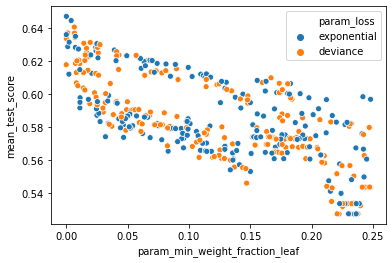

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.scatterplot(x='param_min_weight_fraction_leaf',
                y='mean_test_score',
                data=results.fillna('non'),
                hue='param_loss',
                )
#plt.legend(loc='best')